In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

In [ ]:
from fastai import learner
from fastbook import *
from fastai.text.all import *
from fastai import *
import PIL
from fastai.vision import *
from fastai.vision.widgets import *
from torch.utils.data import dataloader

epoch,train_loss,valid_loss,error_rate,time
0,1.911966,1.556672,0.609195,00:48


epoch,train_loss,valid_loss,error_rate,time
0,1.350784,0.939445,0.402299,01:05
1,1.171117,0.653376,0.252874,01:03
2,0.997472,0.592090,0.218391,01:04
3,0.905864,0.574807,0.218391,01:03


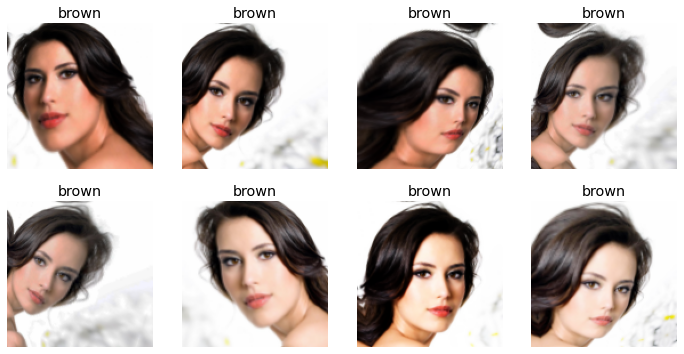

In [7]:
key = os.environ.get('AZURE_SEARCH_KEY', '58d7909f91f347d1943611914fa042f4')
eye_types = 'blue','green','brown'
path = Path('/Users/mahdi/Documents/Sample_Python_files/images/')

### TO DOWNLOAD IMAGES USING BING IMAGE SERVICE
#if not path.exists():
#    path.mkdir()
#for o in eye_types:
    #dest = (path/o)
    #dest.mkdir(exist_ok=True)
    #results = search_images_bing(key, f'{o} eyes')
    #download_images(dest, urls=results.attrgot('content_url'))

fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

eyes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


### TO CHECK LOADING DATA 
#dls = eyes.dataloaders(path)
#dls.valid.show_batch(max_n=4, nrows=1)


### TO CHECK RESIZING WITH BLACK SPACE ON SIDE
#eyes = eyes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
#dls = eyes.dataloaders(path)


### TO APPLY RANDOM CRUP TECHNICHQUE
#eyes = eyes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
#dls = eyes.dataloaders(path)
#dls.train.show_batch(max_n=4, nrows=1, unique=True)

### DATA AUGMENTATION
eyes = eyes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = eyes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### APPLY RANDOM CROP
eyes = eyes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = eyes.dataloaders(path)

### DEFINE LEARNER
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)



In [8]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [15]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): 
    filename = os.path.basename(str(cleaner.fns[idx]))
    shutil.move(os.path.join(str(cleaner.fns[idx])),
    os.path.join(path/cat,filename))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/mahdi/Documents/Sample_Python_files/images/brown/00000045.jpg'

In [16]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

In [25]:
### TO CHOOSE A FILE TO TEST THE MODEL
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [20]:
### TO TEST THE MODEL AND PREDICT
learn_inf.predict('/Users/mahdi/Documents/Sample_Python_files/images/test/test.jpg')

('green', tensor(2), tensor([0.2577, 0.1830, 0.5593]))

In [24]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [29]:
img = PILImage.create(btn_upload.data[-1])
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: green; Probability: 0.5593')

In [34]:
### ADDING NEW EYES TO DB
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

btn_run = widgets.Button(description='Classify')
btn_run

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

#hide_output
VBox([widgets.Label('Add Another EYE!'), 
      btn_upload, btn_run, out_pl, lbl_pred])